# Programming Project #2: Image Quilting

## CS445: Computational Photography - Spring 2020

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os

In [2]:
from utils import cut # default cut function for seam finding section
from PIL import Image

### Part I: Randomly Sampled Texture (10 pts)

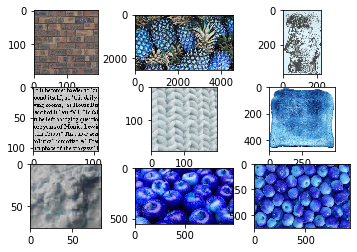

In [3]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
# feynman = cv2.imread("samples/feynman.tiff")
# sketch = cv2.imread("samples/sketch.tiff")
# text_small = cv2.imread("samples/text_small.jpg")
# textureWeave = cv2.imread("samples/texture.png")
# toast = cv2.imread("samples/toast.jpg")
# white_small = cv2.imread("samples/white_small.jpg")

if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
#     plt.imshow(sample_img)

# Visualizing Images on Notebook
# import matplotlib.pyplot as plt
#     %matplotlib inline # or `%matplotlib notebook` for interactive plotting
# #     from PIL import Image
# #     import cv2
#     # read image using PIL and OpenCV library
    image_1 = Image.open("samples/bricks_small.jpg")
#     image_1 = cv2.imread("samples/bricks_small.jpg")
#     image_2 = cv2.imread("samples/feynman.tiff")
    image_2 = cv2.imread("samples/pineapples.jpg")
    image_3 = cv2.imread("samples/sketch.tiff")
    image_4 = cv2.imread("samples/text_small.jpg")
    image_5 = cv2.imread("samples/texture.png")
    image_6 = cv2.imread("samples/toast.jpg")
    image_7 = cv2.imread("samples/white_small.jpg")
    image_8 = cv2.imread("samples/apples.jpg")
    image_9 = cv2.imread("samples/fujiapples.jpg")
    #For Face on Toast
    image_10 = cv2.imread("samples/Aquaman.jpg")
    image_11 = cv2.imread("samples/WonderWoman.jpg")
#     # Display image on notebook
    fig, axes = plt.subplots(3, 3)
    axes[0, 0].imshow(image_1)
    axes[0, 1].imshow(image_2)
    axes[0, 2].imshow(image_3)
    axes[1, 0].imshow(image_4)
    axes[1, 1].imshow(image_5)
    axes[1, 2].imshow(image_6)
    axes[2, 0].imshow(image_7)
    axes[2, 1].imshow(image_8)
    axes[2, 2].imshow(image_9)

In [4]:
# https://www.geeksforgeeks.org/working-images-python/. use open image library from path, crop a patch, paste the patch
# https://code-maven.com/create-images-with-python-pil-pillow -> Results array
def random_patch(sample, patch_size):
    """
    Randomly picks a patch on an image
    """
    random_x = np.random.randint(0, sample.size[0] - patch_size)
    random_y = np.random.randint(0, sample.size[0] - patch_size)
    patchCorners = (random_x, random_y, random_x + patch_size, random_y + patch_size) #identify the 4 corners
    patch = sample.crop(patchCorners)
    return patch
    
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    # Todo 
    sampleImage = Image.fromarray(sample) #convert image matrix parameter to Image 
    output = Image.new("RGB", (out_size, out_size), "black") #results array
    # black along the edges ok if doesn't fit evenly, determined by the floor div, like 20/115, or 420/80
    for x in range(0, out_size//patch_size):
        for y in range(0, out_size//patch_size):
            patch = random_patch(sampleImage, patch_size)
            output.paste(patch, (x*patch_size,y*patch_size, (x+1)*patch_size, (y+1)*patch_size) ) 

    return output

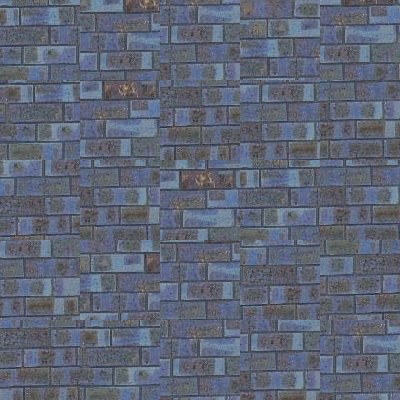

In [5]:
out_size = 400  # feel free to change to debug
patch_size = 80 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
display(res)
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html
# https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html
# https://www.geeksforgeeks.org/change-data-type-of-given-numpy-array/
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook

### Part II: Overlapping Patches (30 pts)

In [6]:
# PseudoCode
# a) Generate scan all possible permutations of patches via an AllPatches, store in obj/dict
# b) Scan the result with ssd_patch (template matching with the overlapping region, computing the cost of sampling each patch, based on (SSD) of the overlapping regions)
# c) Use choose_sample() to run the ssd_patch calculations, build a candidates array with lowest SSD scores, random selection
# d) Use quilt_simple() to iterate through the canvas, grab sample patches that fit the criteria, and place patches in output image

# Tip: For efficiency, use filtering to compute SSD. 
# Note that part of the computation only needs to be done once (not for each patch), so that can be cached. 
# Suppose I have a template T, a mask M, and an image I: then, ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)

# def ssd_patch(T, M, I):
#     ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
#     return ssd

# Scan all possible permutations
def allPatches(sample, patch_size):
    allPatchesDict = {}
    countIndex = 0
    #print("Sample", sample.shape)
    for x in range(sample.shape[0]):
        if sample.shape[0] - x < patch_size:
            break
        for y in range(sample.shape[1]):
            #print("Sample[0, 1]", sample.shape[0], sample.shape[1])
            if sample.shape[1] - y < patch_size:
                continue
            allPatchesDict[countIndex] = sample[x : x + patch_size, y : y + patch_size, :]
            countIndex += 1       
    #print("All Patches", allPatchesDict)
    return allPatchesDict

# patch in the current output image to be filled in (many pixel values will be 0 because they are not filled in yet)
def ssd_patch(M, T, I):
    template = np.zeros(I.shape)
    template[:,:,0], template[:,:,1], template[:,:,2] = M * I[:,:,0], M * I[:,:,1], M * I[:,:,2]
    return np.sum((T - template) ** 2)

# run the ssd_patch calculations, build a candidates array with lowest SSD scores, random selection
def choose_sample(sample, patch_size, M, T, tol, allPatchesDict):
    tolerance = tol #start with low tolerance (e.g., 0.00001)
    imageCosts = {}
    candidates = []
    randomIndex = (np.random.choice(len(allPatchesDict), int(0.1 * len(allPatchesDict))))

    for i in randomIndex:
        imageCosts[i] = ssd_patch(M, T, allPatchesDict[i])
    #minc=max(minc,small_cost_value)
    #grab minimum cost
    minc = min(imageCosts.values()) 
    for key in imageCosts.keys():
        # row, col = np.where(cost < minc*(1+tol)) 
        if imageCosts[key] <= minc * (1 + tolerance):
            candidates.append(allPatchesDict[key])

    randomIndexSelection = np.random.choice(len(candidates))
    return candidates[randomIndexSelection]

# Note: Should only be used within the quilting functions due to local/global
def addSampleToResultImage(x, y, overlap, patch_size, updatedSample, output):
    overlapPixels = overlap // 2
    endX = x + patch_size
    endY = y + patch_size
    
    if x == 0 and y == 0:
        output[x : endX, y : endY] = updatedSample
    elif x == 0 and y != 0:
        output[x: endX, y + overlapPixels : endY] = updatedSample[:, overlapPixels:, :]
    elif x != 0 and y == 0:
        output[x + overlapPixels : endX, y : endY] = updatedSample[overlapPixels:, :, :]
    else:
        output[x + overlapPixels : endX, y + overlapPixels : endY] = updatedSample[overlapPixels:, overlapPixels:, :]

def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    # Todo 
    sample = sample.copy() / 255.0
    output = np.zeros([out_size, out_size, 3]) #results array
    patches = allPatches(sample, patch_size)

    for x in range(0, out_size + 1, patch_size - overlap):
        if out_size - x < patch_size:
            break
        for y in range(0, out_size + 1, patch_size - overlap):
            if out_size - y < patch_size:
                continue

            # auto randomize patch for upper-left corner
            if x == 0 and y == 0:
                index = np.random.choice(len(patches))
                addSampleToResultImage(x, y, overlap, patch_size, patches[index], output)
            M = (output[x : x + patch_size, y : y + patch_size, 0] != 0).astype(int)
            T = (output[x : x + patch_size, y : y + patch_size])
            updatedSample = choose_sample(sample, patch_size, M, T, tol, patches)
            addSampleToResultImage(x, y, overlap, patch_size, updatedSample, output)
    return output

In [7]:
# Use an odd value for patch_size so that its center is well-defined. -> 75
# Extra Image 2 (Used for Testing). Image 1 for this section in next cell.
beardedQuilt = quilt_simple(image_3, 400, 75, 20, 0.00001) #feel free to change parameters to get best results
# plt.figure(figsize = (6,6))
# plt.imshow(beardedQuilt[:,:,:])
# plt.imshow(beardedQuilt[:-10,:-10,:])
# plt.imshow(beardedQuilt[:-25,:-25,:])
# plt.imshow(beardedQuilt[:-50,:-50,:])

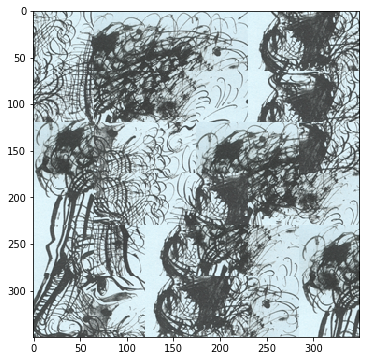

In [8]:
# Clearer Cell
plt.figure(figsize = (6,6))
plt.imshow(beardedQuilt[:-50,:-50,:])

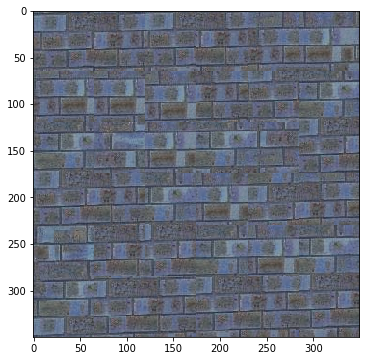

In [9]:
# Same Sample from Random
bricksQuilted = quilt_simple(sample_img, 400, 75, 20, 0.1)
plt.figure(figsize = (6,6))
plt.imshow(bricksQuilted[:-50,:-50,:])

### Part III: Seam Finding (20 pts)


In [ ]:
# Would this actually have been part of B&W?
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [10]:
def cut(err_patch):
    """
    Compute the minimum path frm the left to right side of the patch
    
    :param err_patch: numpy.ndarray    cost of cutting through each pixel
    :return: numpy.ndarray             a 0-1 mask that indicates which pixels should be on either side of the cut
    """
    
    # create padding on top and bottom with very large cost
    padding = np.expand_dims(np.ones(err_patch.shape[1]).T*1e10,0)
    err_patch = np.concatenate((padding, err_patch, padding), axis=0)
    h, w = err_patch.shape
    path = np.zeros([h,w], dtype="int")
    cost = np.zeros([h,w])
    cost[:,0] = err_patch[:, 0]
    cost[0,:] = err_patch[0, :]
    cost[cost.shape[0]-1,:] = err_patch[err_patch.shape[0]-1, :]
    
    # for each column, compute the cheapest connected path to the left
    # cost of path for each row from left upper/same/lower pixel
    for x in range(1,w):
        # cost of path for each row from left upper/same/lower pixel
        tmp = np.vstack((cost[0:h-2,x-1], cost[1:h-1, x-1], cost[2:h, x-1]))
        mi = tmp.argmin(axis=0)
        path[1:h-1, x] = np.arange(1, h-1, 1).T + mi # save the next step of the path
        cost[1:h-1, x] = cost[path[1:h-1, x] - 1, x-1] + err_patch[1:h-1, x]

    path = path[1:path.shape[0]-1, :] - 1
    cost = cost[1:cost.shape[0]-1, :]

    # create the mask based on the best path
    mask = np.zeros(path.shape, dtype="int")
    best_path = np.zeros(path.shape[1], dtype="int")
    best_path[len(best_path)-1] = np.argmin(cost[:, cost.shape[1]-1]) + 1
    mask[0:best_path[best_path.shape[0]-1], mask.shape[1]-1] = 1
    for x in range(best_path.size-1, 0, -1):
        best_path[x-1] = path[best_path[x]-1, x]
        mask[:best_path[x-1], x-1] = 1
    mask ^= 1
    return mask

In [11]:
# Update helper functions
def ssd_patch2(M, T, I):
    template = np.zeros(I.shape)
    template[:,:,0], template[:,:,1], template[:,:,2] = M * I[:,:,0], M * I[:,:,1], M * I[:,:,2]
    return np.sum((T - template) ** 2, -1)

def choose_sample_with_cost(sample, patch_size, M, T, tol, allPatchesDict):
    tolerance = tol
    imageCosts = {}
    imageCostSSD = {}
    candidates = []
    imageCostsArray = []
    randomIndex = (np.random.choice(len(allPatchesDict), int(0.01 * len(allPatchesDict))))

    for i in randomIndex:
        cost = ssd_patch2(M, T, allPatchesDict[i])
        imageCosts[i] = np.sum(cost)
        imageCostSSD[i] = cost
        
    minc = min(imageCosts.values()) 
    for key in imageCosts.keys():
        if imageCosts[key] <= minc * (1 + tolerance):
            candidates.append(allPatchesDict[key])
            imageCostsArray.append(imageCostSSD[key])

    randomIndexSelection = np.random.choice(len(candidates))
    return candidates[randomIndexSelection], imageCostsArray[randomIndexSelection]

In [12]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    sample = sample.copy() / 255.0
    output = np.zeros([out_size, out_size, 3]) #results array
    patches = allPatches(sample, patch_size) #grab all patches for this image
    #Iterate through x and y of the canvas, generate sample image, keeping in mind the low-cost
    for x in range(0, out_size + 1, patch_size - overlap):
        overlapX = x + overlap
        endX = x + patch_size
        if out_size - x < patch_size:
            break
        for y in range(0, out_size + 1, patch_size - overlap):
            overlapY = y + overlap
            endY = y + patch_size
            if out_size - y < patch_size:
                continue
            # Setup Mask and Template
            M = (output[x : endX, y : endY, 0] != 0)
            T = (output[x : endX, y : endY, :])
            newSampleImage, cost = choose_sample_with_cost(sample, patch_size, M, T, tol, patches)
            
            # Upper Corner
            if x == 0 and y == 0:
                addSampleToResultImage(x, y, overlap, patch_size, patches[np.random.choice(len(patches))], output)
            # Account for top and/or left over flaps. Using cut to find the min-cost contiguous path and generate masks
            elif x == 0 and y != 0:
                template = cost[:, 0 : overlap]
                mask1 = cut(template.T).T
                #print(mask1)
                overlappedRegion = output[x : endX, y: overlapY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] = newSampleImage[:,:overlap,z] * mask1  + (1 - mask1) * overlappedRegion[:,:,z]
                output[x:endX, overlapY:endY,:] = newSampleImage[:, overlap:,:]
            elif x != 0 and y == 0:
                mask2 = cut(cost[0 : overlap, :])
                overlappedRegion = output[x : overlapX, y: endY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] =  newSampleImage[:overlap,:,z] * mask2  + (1 - mask2) * overlappedRegion[:,:,z]
                output[overlapX:endX, y:endY,:] = newSampleImage[overlap:,:,:]
            else:
                template = cost[:, 0 : overlap]
                mask3 = cut(template.T).T
                overlappedRegion = output[x : endX, y: overlapY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] = newSampleImage[:,:overlap,z] * mask3  + (1 - mask3) * overlappedRegion[:,:,z]
                mask4 = cut(cost[0 : overlap, :])
                overlappedRegion = output[x : overlapX, y: endY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] =  newSampleImage[:overlap,:,z] * mask4  + (1 - mask4) * overlappedRegion[:,:,z]
                output[overlapX:endX, overlapY:endY,:] = newSampleImage[overlap:,overlap:,:]
    return output

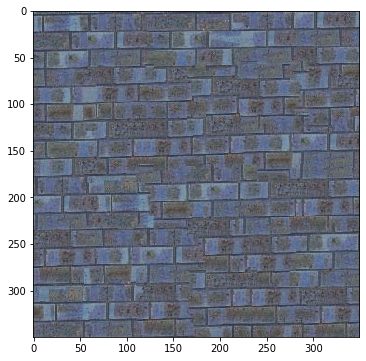

In [13]:
# Image 1. Default to compare against random and overlapping texture samples
bricksCut = quilt_cut(sample_img, 400, 75, 20, 0.001)
plt.figure(figsize = (6,6))
# plt.imshow(bricksCut[:,:,:])
plt.imshow(bricksCut[:-50,:-50,:])

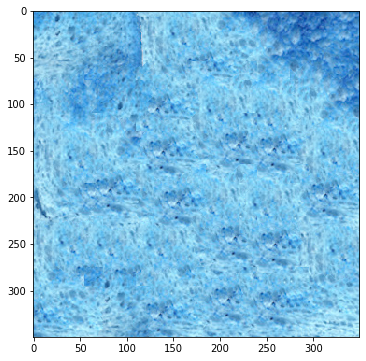

In [14]:
# Image 2
toast = quilt_cut(image_6,  400, 75, 20, 0.002)
plt.figure(figsize = (6,6))
plt.imshow(toast[:-50,:-50,:])

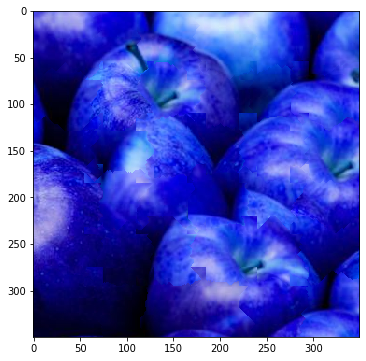

In [15]:
# Image 3. Personal Image
appleQuilted = quilt_cut(image_8,  400, 75, 20, 0.002)
plt.figure(figsize = (6,6))
plt.imshow(appleQuilted[:-50,:-50,:])

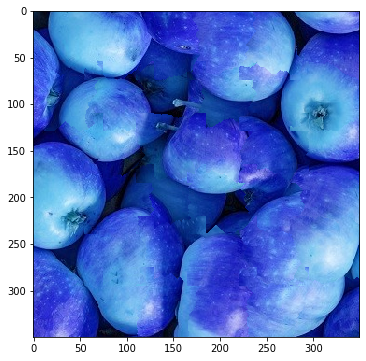

In [18]:
# Image 4. Personal Image
pineappleQuilted = quilt_cut(image_9,  400, 75, 20, 0.002)
plt.figure(figsize = (6,6))
plt.imshow(pineappleQuilted[:-50,:-50,:])

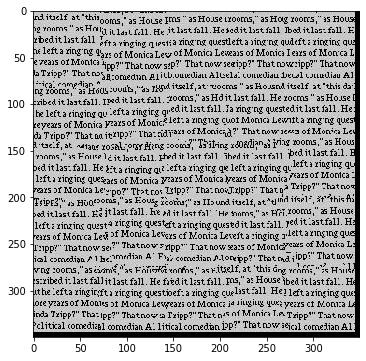

In [19]:
# Image 5. Sample Image
textQuilted = quilt_cut(image_4, 400, 85, 20, 0.1)
plt.figure(figsize = (6,6))
plt.imshow(textQuilted[:-50,:-50,:])

### part III-B: Seam Finding Illustration

In [20]:
def cut2(err_patch):
    """
    Compute the minimum path frm the left to right side of the patch
    
    :param err_patch: numpy.ndarray    cost of cutting through each pixel
    :return: numpy.ndarray             a 0-1 mask that indicates which pixels should be on either side of the cut
    """
    
    # create padding on top and bottom with very large cost
    padding = np.expand_dims(np.ones(err_patch.shape[1]).T*1e10,0)
    err_patch = np.concatenate((padding, err_patch, padding), axis=0)
    h, w = err_patch.shape
    path = np.zeros([h,w], dtype="int")
    cost = np.zeros([h,w])
    cost[:,0] = err_patch[:, 0]
    cost[0,:] = err_patch[0, :]
    cost[cost.shape[0]-1,:] = err_patch[err_patch.shape[0]-1, :]
    
    # for each column, compute the cheapest connected path to the left
    # cost of path for each row from left upper/same/lower pixel
    for x in range(1,w):
        # cost of path for each row from left upper/same/lower pixel
        tmp = np.vstack((cost[0:h-2,x-1], cost[1:h-1, x-1], cost[2:h, x-1]))
        mi = tmp.argmin(axis=0)
        path[1:h-1, x] = np.arange(1, h-1, 1).T + mi # save the next step of the path
        cost[1:h-1, x] = cost[path[1:h-1, x] - 1, x-1] + err_patch[1:h-1, x]

    path = path[1:path.shape[0]-1, :] - 1
    cost = cost[1:cost.shape[0]-1, :]

    # create the mask based on the best path
    mask = np.zeros(path.shape, dtype="int")
    best_path = np.zeros(path.shape[1], dtype="int")
    best_path[len(best_path)-1] = np.argmin(cost[:, cost.shape[1]-1]) + 1
    mask[0:best_path[best_path.shape[0]-1], mask.shape[1]-1] = 1
    for x in range(best_path.size-1, 0, -1):
        best_path[x-1] = path[best_path[x]-1, x]
        mask[:best_path[x-1], x-1] = 1
    mask ^= 1
    return mask, best_path

In [21]:
def quilt_cut2(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    #pass
    sample = sample.copy() / 255.0 #
    output = np.zeros([out_size, out_size, 3]) #results array
    patches = allPatches(sample, patch_size)
    patchArray = []
    for x in range(0, out_size + 1, patch_size - overlap):
        overlapX = x + overlap
        endX = x + patch_size

        if out_size - x < patch_size:
            break
        for y in range(0, out_size + 1, patch_size - overlap):
            overlapY = y + overlap
            endY = y + patch_size
            if out_size - y < patch_size:
                continue
                
            M = (output[x : endX, y : endY, 0] != 0)
            T = (output[x : endX, y : endY, :])
            newSampleImage, cost = choose_sample_with_cost(sample, patch_size, M, T, tol, patches)
            patchArray.append(newSampleImage)
            if x == 0 and y == 0:
                addSampleToResultImage(x, y, overlap, patch_size, patches[np.random.choice(len(patches))], output)
                
#             elif x == 0 and y != 0:
#                 template = cost[:, 0 : overlap]
#                 mask1, bestPath1 = cut2(template.T)
#                 overlappedRegion = output[x : endX, y: overlapY, :]

#                 for z in range(3):
#                     overlappedRegion[:,:,z] = newSampleImage[:,:overlap,z] * mask1.T  + (1 - mask1.T) * overlappedRegion[:,:,z]
#                 output[x:endX, overlapY:endY,:] = newSampleImage[:, overlap:,:]

#                 patch1 = patchArray[0]
#                 patch2 = patchArray[1]
#                 costImage = cost
#                 mask1 = mask1.T
#                 #bestPath1
#                 templateT = template.T
#                 break;
            elif x != 0 and y == 0:
                mask2, bestPath2 = cut2(cost[0 : overlap, :])
                overlappedRegion = output[x : overlapX, y: endY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] =  newSampleImage[:overlap,:,z] * mask2  + (1 - mask2) * overlappedRegion[:,:,z]
                output[overlapX:endX, y:endY,:] = newSampleImage[overlap:,:,:]
                # Setting up the exports
                patch1 = patchArray[0]
                patch2 = patchArray[1]
                costImage = cost
                overlapping = overlappedRegion
                #bestPath
                break;
#             else:
#                 template = cost[:, 0 : overlap]
#                 mask3, bestPath3 = cut2(template.T).T
#                 mask3 = mask3.T
#                 overlappedRegion = output[x : endX, y: overlapY, :]
#                 for z in range(3):
#                     overlappedRegion[:,:,z] = newSampleImage[:,:overlap,z] * mask3  + (1 - mask3) * overlappedRegion[:,:,z]
#                 mask4, bestPath4 = cut2(cost[0 : overlap, :])
#                 overlappedRegion = output[x : overlapX, y: endY, :]
#                 for z in range(3):
#                     overlappedRegion[:,:,z] =  newSampleImage[:overlap,:,z] * mask4  + (1 - mask4) * overlappedRegion[:,:,z]
#                 output[overlapX:endX, overlapY:endY,:] = newSampleImage[overlap:,overlap:,:]
    return patch1, patch2, costImage, bestPath2, mask2

Text(0.5, 1.0, 'Cost Image with Cost Cut')

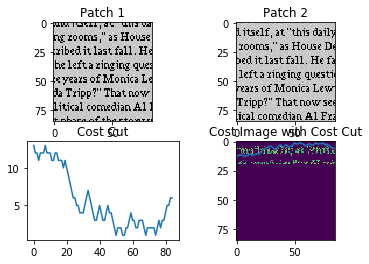

In [22]:
#Seam finding illustration
patch1, patch2, costImage, bestPath, mask2 = quilt_cut2(image_4, 400, 85, 20, 0.1)
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(patch1)
axes[0, 0].set_title('Patch 1')
axes[0, 1].imshow(patch2)
axes[0, 1].set_title('Patch 2')
axes[1, 0].plot(bestPath)
axes[1, 0].set_title('Cost Cut')
axes[1, 1].imshow(costImage)
axes[1, 1].plot(bestPath)
axes[1, 1].set_title('Cost Image with Cost Cut')

### part IV: Texture Transfer (30 pts)

In [23]:
# Update helper functions
# The main difference between this function and quilt_cut is that there is an additional cost term 
# based on the difference between the sampled source patch and the target patch at the location to be filled.
def choose_sample_with_extra_cost(targetImage, patch_size, M, T, tol, allPatchesDict):
    tolerance = tol
    imageCosts = {}
    imageCostSSD = {}
    candidates = []
    imageCostsArray = []
    randomIndex = (np.random.choice(len(allPatchesDict), int(0.01 * len(allPatchesDict))))

    for i in randomIndex:
        # calculating the additional cost. as noted from the paper
        alpha = np.sum(M) / (M.shape[0] * M.shape[1])  
        cost = ssd_patch2(M, T, allPatchesDict[i])
        cost2 = ssd_patch2(np.ones([patch_size, patch_size]), targetImage, allPatchesDict[i])
        imageCosts[i] = alpha * np.sum(cost) + (1 - alpha) * np.sum(cost2)
        imageCostSSD[i] = cost

    minc = min(imageCosts.values()) 
    for key in imageCosts.keys():
        if imageCosts[key] <= minc * (1 + tolerance):
            candidates.append(allPatchesDict[key])
            imageCostsArray.append(imageCostSSD[key])

    randomIndexSelection = np.random.choice(len(candidates))
    return candidates[randomIndexSelection], imageCostsArray[randomIndexSelection]

In [24]:
def texture_transfer(texture, target, patch_size, overlap, tol):
    texture = texture.copy() / 255.0
    output = target.copy() / 255.0
    patches = allPatches(texture, patch_size)
    
    for x in range(0, target.shape[0], patch_size - overlap):
        overlapX = x + overlap
        endX = x + patch_size
        if target.shape[0] - x < patch_size:
            break
        for y in range(0, target.shape[1], patch_size - overlap):
            overlapY = y + overlap
            endY = y + patch_size
            if target.shape[1] - y < patch_size:
                continue
            M = (output[x : endX, y : endY, 0] != 0).astype(int)
            T = (output[x : endX, y : endY, :])
            newTexturedImage, cost = choose_sample_with_extra_cost(output[x:endX, y:endY], patch_size, M, T, tol, patches)
            
            if x == 0 and y == 0:
                addSampleToResultImage(x, y, overlap, patch_size, newTexturedImage, output)
            elif x == 0 and y != 0:
                template = cost[:, 0 : overlap]
                mask1 = cut(template.T).T
                overlappedRegion = output[x : endX, y: overlapY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] = newTexturedImage[:,:overlap,z] * mask1  + (1 - mask1) * overlappedRegion[:,:,z]
                output[x:endX, overlapY:endY,:] = newTexturedImage[:, overlap:,:]
            elif x != 0 and y == 0:
                mask2 = cut(cost[0 : overlap, :]) 
                overlappedRegion = output[x : overlapX, y: endY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] =  newTexturedImage[:overlap,:,z] * mask2  + (1 - mask2) * overlappedRegion[:,:,z]
                output[overlapX:endX, y:endY,:] = newTexturedImage[overlap:,:,:]
            else:
                template = cost[:, 0 : overlap]
                mask3 = cut(template.T).T
                overlappedRegion = output[x : endX, y: overlapY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] = newTexturedImage[:,:overlap,z] * mask3  + (1 - mask3) * overlappedRegion[:,:,z]
                mask4 = cut(cost[0 : overlap, :])
                overlappedRegion = output[x : overlapX, y: endY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] =  newTexturedImage[:overlap,:,z] * mask4  + (1 - mask4) * overlappedRegion[:,:,z]
                output[overlapX:endX, overlapY:endY,:] = newTexturedImage[overlap:,overlap:,:]
    return output

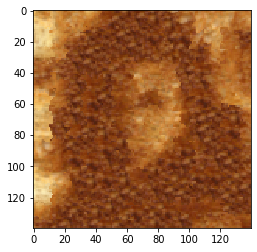

In [25]:
# Image Result #1. One is mine as the target and the other is the source texture
sizeDown = cv2.pyrDown(image_6)
sizeDownPerson = cv2.pyrDown(image_11)
coloredToast = cv2.cvtColor(sizeDown, cv2.COLOR_BGR2RGB)
coloredPerson = cv2.cvtColor(sizeDownPerson, cv2.COLOR_BGR2RGB)[:,75:-75,:]
# print(coloredToast.shape)
# print(coloredPerson.shape)
# plt.imshow(coloredToast)
# plt.imshow(coloredPerson)
# plt.show()
wonderToast = texture_transfer(coloredToast, coloredPerson, 15, 5, 0.1)
# plt.imshow(wonderToast[:, :, :])
plt.imshow(wonderToast[:-10, :-10, :])

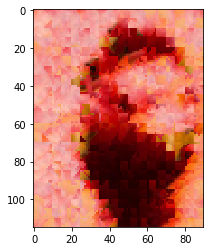

In [26]:
# Image Result #1. One is mine as the target and the other is the source texture
sizeDown = cv2.pyrDown(image_8)
sizeDownPerson = cv2.pyrDown(image_10)
coloredFruit = cv2.cvtColor(sizeDown, cv2.COLOR_BGR2RGB)[125:225,250:350,:]
coloredPerson = cv2.cvtColor(sizeDownPerson, cv2.COLOR_BGR2RGB)[25:150,200:300,:]
# plt.imshow(coloredFruit)
# plt.imshow(coloredPerson)
# plt.show()
aquaApple = texture_transfer(coloredFruit, coloredPerson, 10, 5, 0.1)
# plt.imshow(aquaApple[:, :, :])
plt.imshow(aquaApple[:-10, :-10, :])

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

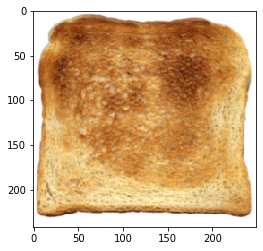

In [27]:
# Texture Transfer
sizeDown2 = cv2.pyrDown(image_6)
sizeDownPerson2 = cv2.pyrDown(image_11)
coloredToast2 = cv2.cvtColor(sizeDown2, cv2.COLOR_BGR2RGB)
coloredPerson2 = cv2.cvtColor(sizeDownPerson2, cv2.COLOR_BGR2RGB)[:,:-50,:]
coloredPerson3 = cv2.resize(coloredPerson2, (250, 242), 1, 1)
# print(coloredToast2.shape)
# print(coloredPerson2.shape)
# print(coloredPerson3.shape)
plt.figure(figsize = (4,4))
plt.imshow(coloredToast)
# plt.imshow(coloredPerson3)
plt.show()
# wonderToast = texture_transfer(coloredToast, coloredPerson3, 15, 5, 0.1) #toast is target

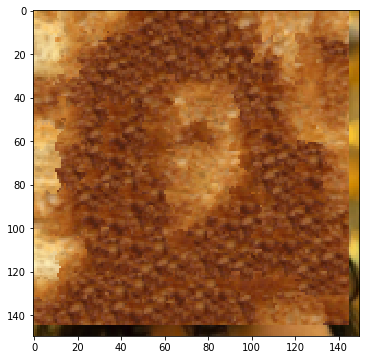

In [28]:
# Check Before Combination
plt.figure(figsize = (6,6))
plt.imshow(wonderToast[:, :, :])

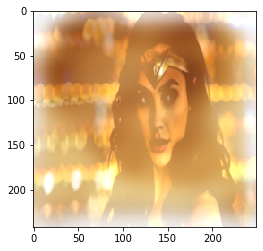

In [29]:
#Blending: Gaussian Blur
def hybridImage(im1, im2, cutoff_low, cutoff_high):
    lowPassImage = cv2.GaussianBlur(im1, (45,45), cutoff_low)
    lowPassImage2 = cv2.GaussianBlur(im2, (45,45), cutoff_high)
    highPassImage = cv2.subtract(im2, lowPassImage2)
    hybridImage = cv2.add(lowPassImage, highPassImage)
    return hybridImage

im1 = cv2.cvtColor(image_6, cv2.COLOR_BGR2RGB) / 255.0
im2 = cv2.cvtColor(image_11, cv2.COLOR_BGR2RGB) / 255.0

im_hybrid = hybridImage(coloredToast2, coloredPerson3, 10, 30)
plt.figure(figsize = (4,4))
plt.imshow(im_hybrid)

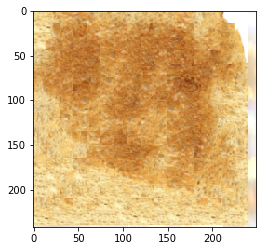

In [30]:
wonderToast2 = texture_transfer(coloredToast, im_hybrid, 30, 15, 0.01)
plt.figure(figsize = (4,4))
plt.imshow(wonderToast2[:, :, :])

In [31]:
# If you look closely, you can see the outline of her hair from im_hybrid and the subsequent face.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).